### Setting up

In [46]:
# Importing packages

import sys
import os
import numpy as np
import pandas as pd
import pymc as pm 
import arviz as az
import matplotlib.pyplot as plt
from typing import List, Dict, Any

In [47]:
# Controlling parameters for chains and randomness

SEED = 42
OUTDIR = "./exchange_rate_forecast"
N_SAMPLES = 5000
CORES = 1
CHAINS = 4

np.random.seed(SEED)

In [48]:
# Managing the files

os.makedirs(OUTDIR, exist_ok=True)

def save_fig(fig: plt.Figure, fig_name: str, outdir: str, tight_layout: bool = True, fig_extension: str = "png", resolution: int = 300):
    os.makedirs(outdir, exist_ok=True)
    path = os.path.join(outdir, f"{fig_name}.{fig_extension}")
    if tight_layout:
        fig.tight_layout()
    fig.savefig(path, format=fig_extension, dpi=resolution)

### Preprocessing the data

In [49]:
# Generate fake time series data
n_days = 10
time = np.arange(n_days)
previous_rate = np.random.normal(5.1, 0.2, n_days)
inflation_us = np.random.normal(3.5, 0.5, n_days) / 100  # Convert to decimal
inflation_brazil = np.random.normal(4.0, 0.5, n_days) / 100  # Convert to decimal    

# Generate target variable (next day's exchange rate)
noise = np.random.normal(0, 0.1, n_days)
exchange_rate = previous_rate + 0.1 * (inflation_brazil - inflation_us) + noise

In [50]:
def exchange_rate_model():
    with pm.Model() as model:
        # Priors for unknown model parameters
        beta_previous = pm.Normal('beta_previous', mu=1, sigma=0.1)
        beta_inflation_diff = pm.Normal('beta_inflation_diff', mu=0.1, sigma=0.1)
        sigma = pm.HalfNormal('sigma', sigma=0.1)
        
        # Expected value of outcome
        mu = (beta_previous * previous_rate + 
              beta_inflation_diff * (inflation_brazil - inflation_us))
        
        # Likelihood (sampling distribution) of observations
        Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=exchange_rate)
        
    return model

model = exchange_rate_model()

### Distribution for each prior:

Sampling: [Y_obs, beta_inflation_diff, beta_previous, sigma]


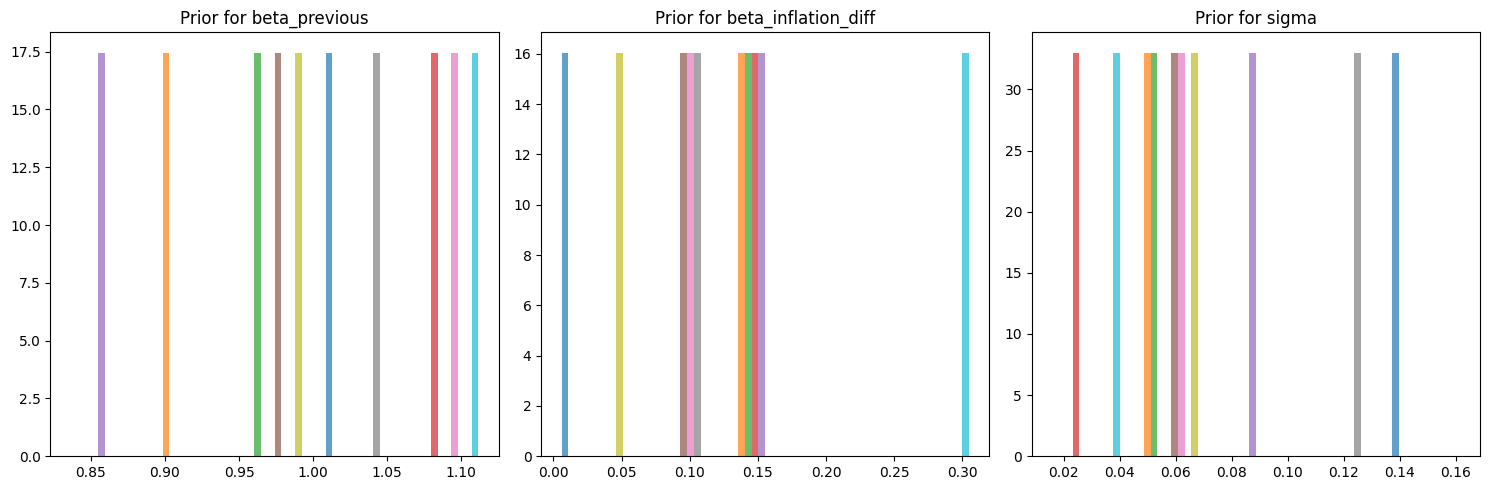

In [51]:
# Plot the distribution for each prior
with model:
    prior_samples = pm.sample_prior_predictive(samples=10)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.hist(prior_samples.prior['beta_previous'], bins=5, density=True, alpha=0.7)
ax1.set_title('Prior for beta_previous')
ax2.hist(prior_samples.prior['beta_inflation_diff'], bins=5, density=True, alpha=0.7)
ax2.set_title('Prior for beta_inflation_diff')
ax3.hist(prior_samples.prior['sigma'], bins=5, density=True, alpha=0.7)
ax3.set_title('Prior for sigma')
plt.tight_layout()
plt.show()

### Histogram of the data and the prior predictive:

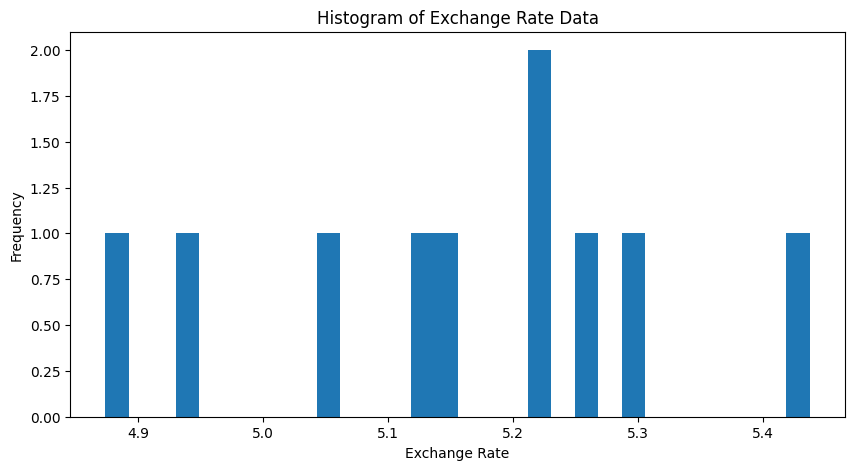

In [52]:
# Plot a histogram of the data
plt.figure(figsize=(10, 5))
plt.hist(exchange_rate, bins=30)
plt.title('Histogram of Exchange Rate Data')
plt.xlabel('Exchange Rate')
plt.ylabel('Frequency')
plt.show()

### Distribution for each posterior:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_previous, beta_inflation_diff, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 90 seconds.


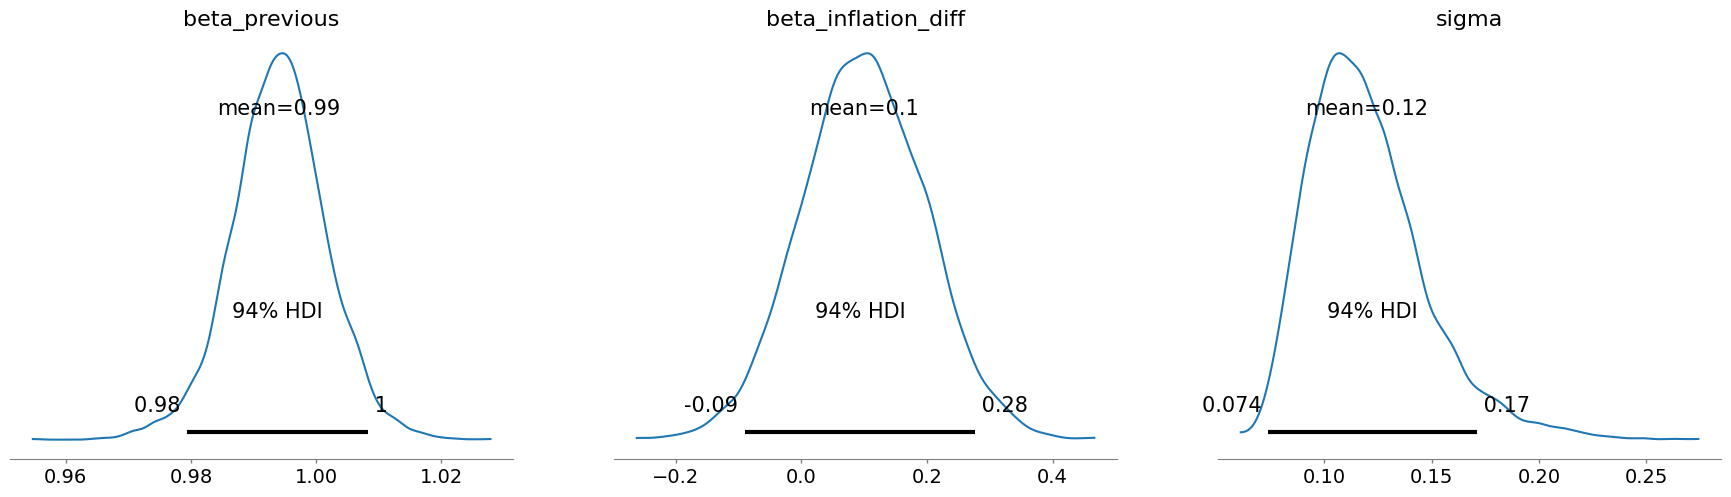

In [53]:
# 3. Sample from the posterior
with model:
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

# 4. Plot the distribution for each posterior
az.plot_posterior(trace, var_names=['beta_previous', 'beta_inflation_diff', 'sigma'])
plt.show()

### Distribution for posterior predictive:

Sampling: [Y_obs]


Output()

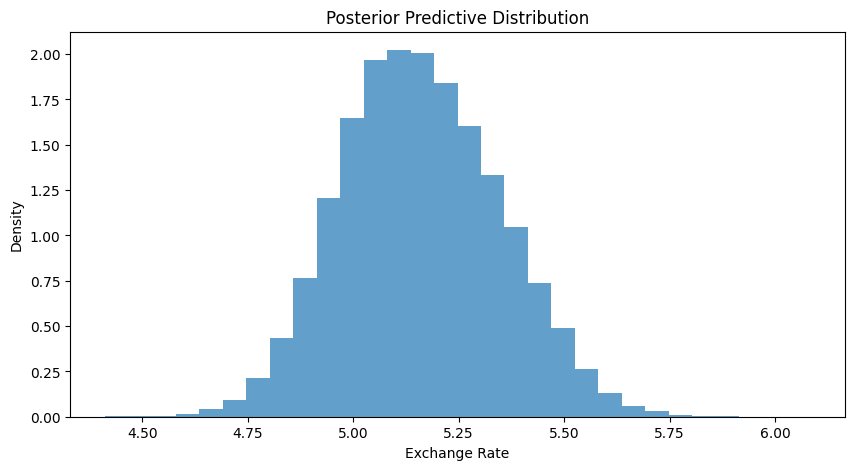

In [54]:
# 5. Plot the posterior predictive distribution
with model:
    ppc = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

plt.figure(figsize=(10, 5))
plt.hist(ppc.posterior_predictive['Y_obs'].values.flatten(), bins=30, density=True, alpha=0.7)
plt.title('Posterior Predictive Distribution')
plt.xlabel('Exchange Rate')
plt.ylabel('Density')
plt.show()